In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import Imputer
from imblearn.over_sampling import SMOTE
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools
from sklearn.metrics import roc_auc_score
from xgboost import plot_importance
from sklearn.feature_selection import SelectFromModel

In [2]:
def read_CSV(file_path):
    df = pd.read_csv(file_path)
    return df

def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
file_path = r'C:\Users\lwj\Documents\Python Scripts\zhaoshang\cleaned_train_all.csv'
train_df = read_CSV(file_path)


In [4]:
y = train_df.flag
#x = train_df.drop(['flag','id'], axis=1).select_dtypes(exclude=['object'])
x = train_df.drop(['flag','id'], axis=1)

In [5]:
train_X, val_X, train_y, val_y = train_test_split(x.as_matrix(), y.as_matrix(), test_size=0.2)

G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.


In [6]:
train_X.shape

(30967, 86)

In [7]:
smo = SMOTE(random_state=42)
X_smo, y_smo = smo.fit_sample(train_X, train_y)

In [30]:
from imblearn.over_sampling import ADASYN
#ADASYN过采样
X_ada, y_ada = ADASYN().fit_resample(train_X, train_y)

In [22]:
#recall:0.54 AUC:0.63
from imblearn.under_sampling import EditedNearestNeighbours
enn = EditedNearestNeighbours()
X_enn, y_enn = enn.fit_resample(train_X, train_y)

In [8]:
#recall:0.76 AUC:0.61
from imblearn.under_sampling import RepeatedEditedNearestNeighbours
renn = RepeatedEditedNearestNeighbours()
X_renn, y_renn = renn.fit_resample(train_X, train_y)

In [14]:
#recall:0.63 AUC:0.62
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=0)
X_rus, y_rus = rus.fit_resample(train_X, train_y)

In [18]:
#recall:0.63 AUC:0.62
from imblearn.under_sampling import NearMiss
nm1 = NearMiss(version=1)
X_nm1, y_nm1 = nm1.fit_resample(train_X, train_y)

In [7]:
test_df = read_CSV(r'cleaned_testb_all.csv')
print(len(test_df))
test_x = test_df.drop(['id'],axis=1).select_dtypes(exclude=['object']).as_matrix()
print(test_x.shape)

4000
(4000, 86)


G:\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
#gbm = xgb.XGBClassifier(silent=1, max_depth=10,objective = 'binary:logistic',n_estimators=1000, learning_rate=0.05)

gbm = xgb.XGBClassifier(silent=1, max_depth=10,n_estimators=1000, learning_rate=0.05)
#gbm.fit(X_smo, y_smo)
#gbm.fit(train_X, train_y)
gbm.fit(X_renn, y_renn)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.05, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=1, subsample=1, verbosity=1)

In [9]:
gbm.feature_importances_

array([0.01964882, 0.01981505, 0.01373825, 0.0286262 , 0.02386912,
       0.02784169, 0.02007578, 0.02213596, 0.02258779, 0.01920742,
       0.01974571, 0.01951571, 0.01884956, 0.01595884, 0.03316143,
       0.01960053, 0.02113873, 0.01889868, 0.01254433, 0.01659691,
       0.00696845, 0.00437074, 0.02830476, 0.01616371, 0.03293088,
       0.02189358, 0.02187164, 0.03362975, 0.02756399, 0.02248241,
       0.01936878, 0.02042556, 0.01975449, 0.02324257, 0.01875081,
       0.02631362, 0.        , 0.        , 0.02337839, 0.01957428,
       0.02776443, 0.01118539, 0.0305674 , 0.02185949, 0.02125824,
       0.02003575, 0.02262109, 0.02293582, 0.02122744], dtype=float32)

In [9]:
selection = SelectFromModel(gbm, threshold='mean', prefit=True)
print(train_X)
select_train_X = selection.transform(X_renn)
# train model
selection_model = xgb.XGBClassifier(silent=1, max_depth=10,n_estimators=1000, learning_rate=0.05)
selection_model.fit(select_train_X, y_renn)
# eval model
select_val_X = selection.transform(val_X)

[[27.  1.  0. ...  0.  0.  0.]
 [41. 10.  0. ...  0.  0.  0.]
 [49.  0.  0. ...  0.  0.  0.]
 ...
 [36.  2.  0. ...  0.  0.  0.]
 [22.  0.  0. ...  0.  0.  0.]
 [30.  4.  0. ...  0.  0.  0.]]


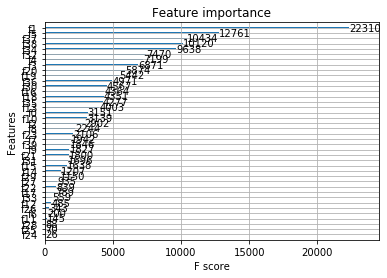

In [16]:
plot_importance(gbm)
from matplotlib import pyplot
pyplot.show()

In [10]:
#predictions = gbm.predict_proba(val_X)
#predictions = gbm.predict(val_X)
#predictions = gbm.predict(train_X)
#predictions = selection_model.predict(select_val_X)
predictions = gbm.predict(test_x)

测试集Recall:  0.6677927927927928


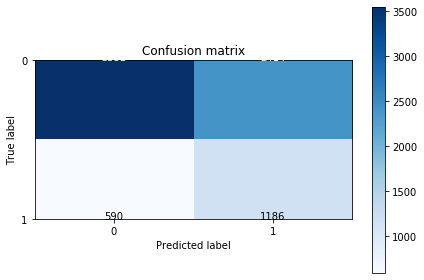

0.6315832887866075


In [11]:
cnf_matrix = confusion_matrix(val_y,predictions)
np.set_printoptions(precision=2)
print("测试集Recall: ", cnf_matrix[1,1]/(cnf_matrix[1,0]+cnf_matrix[1,1]))
class_names = [0,1]
plt.figure()
plot_confusion_matrix(cnf_matrix
                      , classes=class_names
                      , title='Confusion matrix')
plt.show()
auc_score2 = roc_auc_score(val_y,predictions)
print(auc_score2)

In [15]:
#print(predictions)
submission = pd.DataFrame({'flag': predictions})

submission = pd.concat([test_df['id'],submission], axis=1)
#submission.to_csv("submission.csv",index=False)
submission.to_csv('submissionb_0503_21.txt', sep='\t', index=False, header = None ,encoding='utf-8')

In [83]:
submission

,id,flag
0,UC37930,0.183088
1,U5BE130,0.030117
2,UD025AE,0.016644
3,UC2D00D,0.082113
4,UAF705D,0.018818
...,...,...
5995,U71611F,0.516733
5996,U52CFE4,0.724199
5997,U6A5425,0.374458
5998,UB8871F,0.504743
